# Credit card fraud detection models

## Dataset's author info

Content
The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import os
import pickle
import itertools

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

In [2]:
data = pd.read_csv('data/creditcard_subset.csv')

## Data analysis

In [3]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,127614.0,2.004188,-0.287498,-1.984934,0.342239,0.413188,-0.815346,0.445456,-0.299258,0.562445,...,-0.038661,-0.127194,0.036464,0.504076,0.176423,0.541252,-0.121212,-0.064948,64.99,0
1,139389.0,2.346905,-1.264915,-1.034900,-1.568721,-1.122435,-0.790624,-1.011732,-0.268243,-1.229191,...,-0.196288,0.015015,0.197023,-0.432445,-0.119139,-0.131627,0.015176,-0.058104,1.00,0
2,68482.0,-3.089671,2.464689,0.042745,1.670674,-2.129076,0.600262,-1.627286,2.452801,0.319063,...,-0.223384,-0.441265,0.250283,0.091483,-0.038373,-0.410096,0.088944,0.026973,30.70,0
3,123677.0,1.792358,-0.384458,-2.170063,0.096243,0.291162,-1.510182,0.921037,-0.525263,-0.088484,...,0.297749,0.633531,-0.176001,0.146116,0.342753,0.198887,-0.117734,-0.061706,154.09,0
4,121222.0,2.188008,-0.400212,-1.627908,-0.225692,-0.133549,-1.273351,0.226144,-0.553975,-0.908684,...,-0.338599,-0.220436,0.112804,0.049313,0.157236,0.606729,-0.063450,-0.071105,10.00,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213605 entries, 0 to 213604
Data columns (total 31 columns):
Time      213605 non-null float64
V1        213605 non-null float64
V2        213605 non-null float64
V3        213605 non-null float64
V4        213605 non-null float64
V5        213605 non-null float64
V6        213605 non-null float64
V7        213605 non-null float64
V8        213605 non-null float64
V9        213605 non-null float64
V10       213605 non-null float64
V11       213605 non-null float64
V12       213605 non-null float64
V13       213605 non-null float64
V14       213605 non-null float64
V15       213605 non-null float64
V16       213605 non-null float64
V17       213605 non-null float64
V18       213605 non-null float64
V19       213605 non-null float64
V20       213605 non-null float64
V21       213605 non-null float64
V22       213605 non-null float64
V23       213605 non-null float64
V24       213605 non-null float64
V25       213605 non-null float64
V26  

In [5]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,...,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000,213605.000000
mean,94763.710592,0.000761,-0.000864,-0.000395,-0.000124,0.000037,-0.001235,-0.000793,0.000741,0.002086,...,0.000008,0.000888,-0.000716,-0.000077,0.000786,0.000293,-0.000320,-0.000183,88.408696,0.001727
std,47521.370536,1.959843,1.656822,1.514786,1.412014,1.367172,1.324434,1.218273,1.194886,1.098027,...,0.729790,0.726021,0.632531,0.605641,0.522326,0.482457,0.401070,0.328280,248.726927,0.041527
min,0.000000,-56.407510,-72.715728,-33.680984,-5.683171,-42.147898,-26.160506,-43.557242,-50.943369,-13.434066,...,-22.889347,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-11.710896,0.000000,0.000000
25%,54113.000000,-0.919923,-0.597928,-0.891674,-0.845828,-0.693702,-0.768408,-0.555589,-0.208845,-0.639825,...,-0.228160,-0.541214,-0.161916,-0.353719,-0.316995,-0.327013,-0.070970,-0.052880,5.580000,0.000000
50%,84629.000000,0.019950,0.065295,0.180284,-0.018836,-0.055078,-0.274951,0.040626,0.022431,-0.048788,...,-0.029198,0.007580,-0.011943,0.041112,0.017457,-0.052342,0.001158,0.011244,22.000000,0.000000
75%,139282.000000,1.315599,0.803606,1.028480,0.743107,0.611668,0.398198,0.569214,0.327296,0.599340,...,0.186690,0.527844,0.146825,0.439075,0.352142,0.241358,0.090808,0.078129,77.010000,0.000000
max,172792.000000,2.451888,22.057729,9.382558,16.875344,34.801666,23.917837,44.054461,19.587773,15.594995,...,27.202839,8.361985,20.803344,4.016342,7.519589,3.517346,12.152401,33.847808,19656.530000,1.000000


In [6]:
data['Class'].value_counts()

0    213236
1       369
Name: Class, dtype: int64

In [7]:
len(data[data['Class'] == 1])/len(data)*100

0.17274876524425925

It's true that the dataset is highly unbalanced, the positive class (frauds) make only 0.173% of all transactions.

In [8]:
from sklearn.preprocessing import StandardScaler
scaled_data = data.copy()

col_names = list(data.columns.values)
col_names.pop()

features = scaled_data[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

scaled_data[col_names] = features
scaled_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.691276,1.022241,-0.173003,-1.310115,0.242465,0.302195,-0.614688,0.366298,-0.251070,0.510334,...,-0.052985,-0.176417,0.058779,0.832431,0.336259,1.121261,-0.301425,-0.197285,-0.094154,0
1,0.939059,1.197111,-0.762939,-0.682940,-1.110895,-0.821019,-0.596022,-0.829815,-0.225114,-1.121357,...,-0.268975,0.019458,0.312616,-0.713904,-0.229599,-0.273436,0.038637,-0.176437,-0.351425,0
2,-0.553052,-1.576881,1.488125,0.028479,1.183276,-1.557315,0.454155,-1.335083,2.052133,0.288679,...,-0.306104,-0.609010,0.396817,0.151179,-0.074971,-0.850626,0.222565,0.082723,-0.232017,0
3,0.608429,0.914156,-0.231525,-1.432330,0.068249,0.212940,-1.139318,0.756672,-0.440214,-0.082485,...,0.407984,0.871386,-0.277118,0.241386,0.654702,0.411630,-0.292753,-0.187409,0.264071,0
4,0.556767,1.116035,-0.241034,-1.074420,-0.159749,-0.097710,-0.960500,0.186278,-0.464243,-0.829463,...,-0.463980,-0.304845,0.179469,0.081549,0.299526,1.256977,-0.157405,-0.216039,-0.315241,0


Standardization will make our SVM model faster. It is important because we have features with different ranges in dataset.|

In [9]:
scaled_data['Class'] = scaled_data['Class'].replace(1, -1)
scaled_data['Class'] = scaled_data['Class'].replace(0, 1)

Labels have changed due to the subsequent use of Isolation Forest, which generates results {-1, 1}.

In [10]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(scaled_data, scaled_data["Class"]):
    strat_train_set = scaled_data.loc[train_index]
    strat_test_set = scaled_data.loc[test_index]

X_train = strat_train_set.drop('Class', axis=1, inplace = False)
y_train  = strat_train_set[['Class']]

X_test = strat_test_set.drop('Class', axis=1, inplace = False)
y_test  = strat_test_set[['Class']]

In [11]:
corr_matrix = data.corr()
correlations = corr_matrix['Class'].sort_values(ascending=False).drop('Class')

Text(0.5, 1.0, 'Correlations with label column')

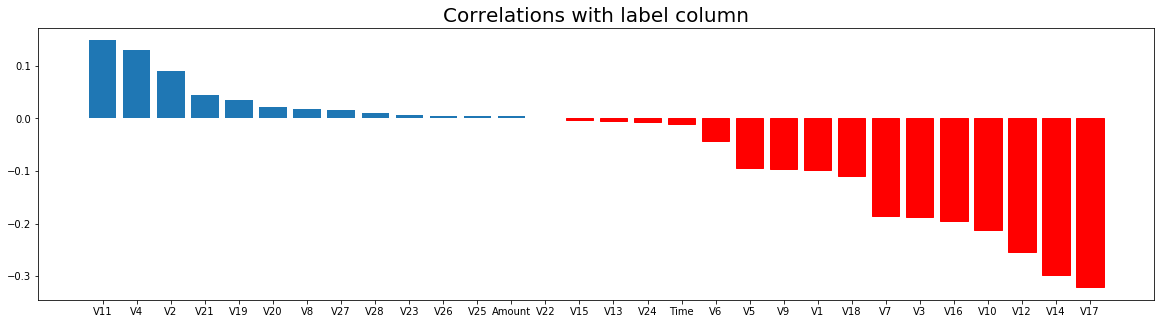

In [12]:
%matplotlib inline
f = plt.figure(figsize=(20,5))
ax = f.add_subplot(1,1,1)
plt.bar(correlations.index, correlations)
for i in range(len(correlations)):
    if correlations[i] < 0:
        ax.get_children()[i].set_color('r') 
plt.title('Correlations with label column', fontsize=20)

In [13]:
list_of_new_columns = correlations[abs(correlations) >= abs(correlations['V23'])]
list_of_new_columns

V11     0.148134
V4      0.129804
V2      0.090604
V21     0.043677
V19     0.035126
V20     0.021034
V8      0.016856
V27     0.015429
V28     0.010787
V23     0.005403
V24    -0.007168
Time   -0.011398
V6     -0.042699
V5     -0.094054
V9     -0.096501
V1     -0.097377
V18    -0.110544
V7     -0.185145
V3     -0.187803
V16    -0.194608
V10    -0.212193
V12    -0.254211
V14    -0.296839
V17    -0.321386
Name: Class, dtype: float64

Now we have list with enough correlated features. We will train models with all features and selected features to compare results

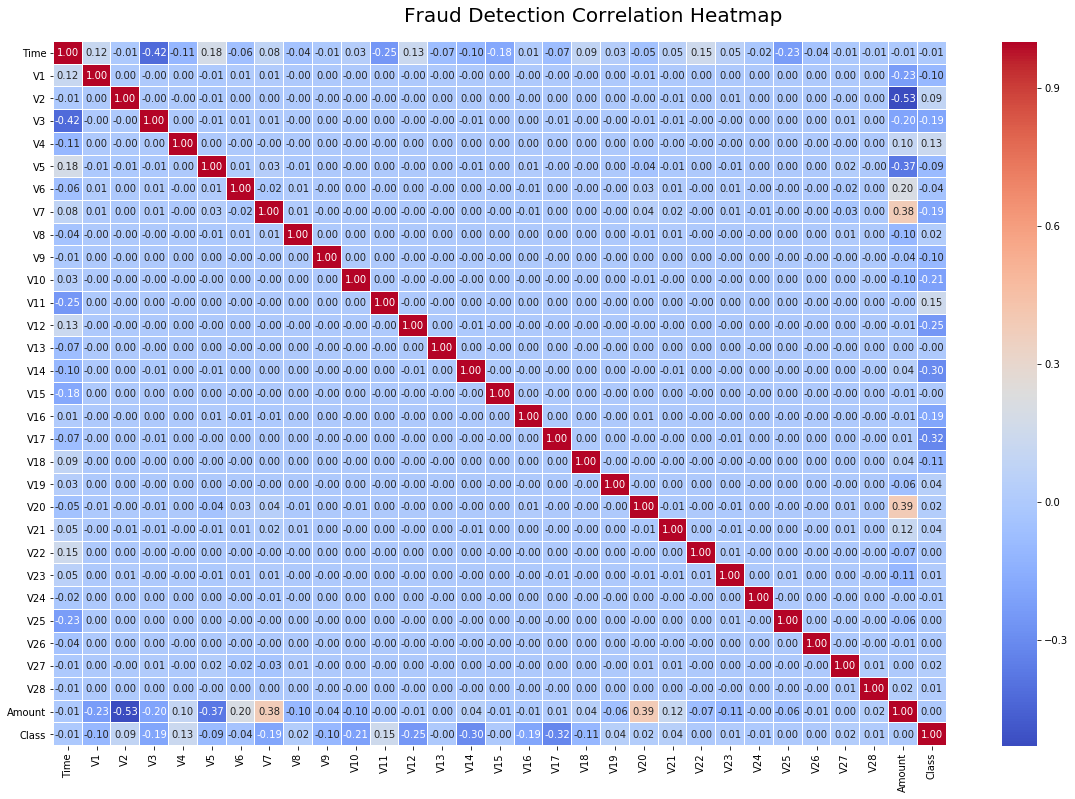

In [14]:
import seaborn as sns

# Correlation Matrix Heatmap
f, ax = plt.subplots(figsize=(20, 12))
hm = sns.heatmap(round(corr_matrix,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

f.subplots_adjust(top=0.94)
t= f.suptitle('Fraud Detection Correlation Heatmap', fontsize=20)

Visualization of correlation matrix could help us to understand rest of the features. For instance $V_{2}$ feature is higly correlated with $Amount$ and $V_{3}$ is highly correlated with $Time$. 

In [15]:
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

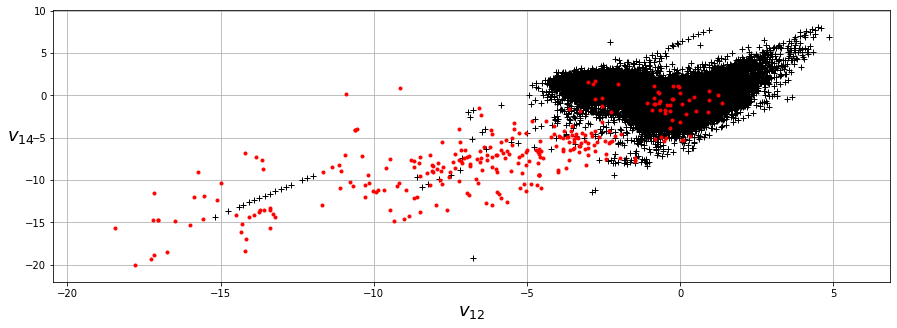

In [16]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(111)


index_0 = [not (i-1) for i in y_train.values]
index_1 = [not i for i in index_0]

ax.plot(X_train[['V12', 'V14']].values[index_0, 0], X_train[['V12', 'V14']].values[index_0, 1], "k+")

ax.plot(X_train[['V12', 'V14']].values[index_1, 0], X_train[['V12', 'V14']].values[index_1, 1], "r.")

ax.set_xlabel("$v_{12}$", fontsize=18)
ax.set_ylabel("$v_{14}$", fontsize=18, rotation=0)
ax.axis([min(X_train[['V12', 'V14']].values[:, 0]) - 2, max(X_train[['V12', 'V14']].values[:, 0]) + 2
         , min(X_train[['V12', 'V14']].values[:, 1]) - 2, max(X_train[['V12', 'V14']].values[:, 1]) + 2])
ax.grid(True)


2D visualization based on two most correlated with $Class$ features.

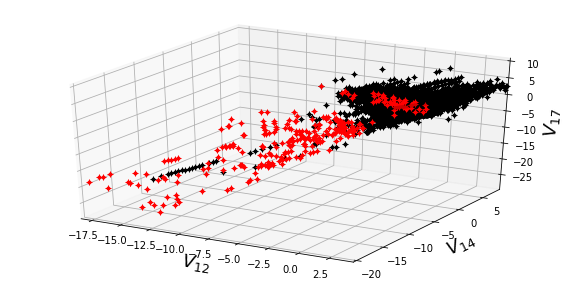

In [17]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='3d')


ax.plot_surface(x1, x2, x1, alpha=0.2, color="k")

ax.plot([0], [0], [0], "k.")


ax.plot(X_train[['V12', 'V14', 'V17']].values[index_0, 0], X_train[['V12', 'V14', 'V17']].values[index_0, 1], X_train[['V12', 'V14', 'V17']].values[index_0, 2], "k+")
ax.plot(X_train[['V12', 'V14', 'V17']].values[index_0, 0], X_train[['V12', 'V14', 'V17']].values[index_0, 1], X_train[['V12', 'V14', 'V17']].values[index_0, 2], "k.")

ax.plot(X_train[['V12', 'V14', 'V17']].values[index_1, 0], X_train[['V12', 'V14', 'V17']].values[index_1, 1], X_train[['V12', 'V14', 'V17']].values[index_1, 2], "r+")
ax.plot(X_train[['V12', 'V14', 'V17']].values[index_1, 0], X_train[['V12', 'V14', 'V17']].values[index_1, 1], X_train[['V12', 'V14', 'V17']].values[index_1, 2], "r.")

ax.set_xlabel("$V_{12}$", fontsize=18)
ax.set_ylabel("$V_{14}$", fontsize=18)
ax.set_zlabel("$V_{17}$", fontsize=18)

ax.set_xlim(int(min(X_train[['V12', 'V14', 'V17']].values[:, 0])), int(max(X_train[['V12', 'V14', 'V17']].values[:, 0])))
ax.set_ylim(int(min(X_train[['V12', 'V14', 'V17']].values[:, 1])), int(max(X_train[['V12', 'V14', 'V17']].values[:, 1])))
ax.set_zlim(int(min(X_train[['V12', 'V14', 'V17']].values[:, 2])), int(max(X_train[['V12', 'V14', 'V17']].values[:, 2])))

plt.show()

3D visualization based on three most correlated with $Class$ features.

In [18]:
current_dir = os.getcwd()
if not os.path.isdir('models'):
            os.makedirs('models')
models_dir = current_dir + '/models'

In [19]:
from imblearn.combine import SMOTEENN

if 'X_train_resampled.txt' in os.listdir(current_dir + '/data') and 'y_train_resampled.txt' in os.listdir(current_dir + '/data'):
    X_train_resampled = np.loadtxt('data/X_train_resampled.txt', dtype=float)
    y_train_resampled = np.loadtxt('data/y_train_resampled.txt', dtype=int)

else:
    smote = SMOTEENN(1/8)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train['Class'])
    np.savetxt('data/X_train_resampled.txt', X_train_resampled, fmt='%f')
    np.savetxt('data/y_train_resampled.txt', y_train_resampled, fmt='%d')

Using TensorFlow backend.


Combination of undersampling and oversampling. One of the most important steps in dealing with imbalanced data. We resampled data in 1:8 proportion to split it into seven independent training sets.

## Splitting training set into 8 independent sets

In [20]:
data_train = np.c_[X_train_resampled, y_train_resampled]
data_train = pd.DataFrame(data_train, columns=data.columns.values)

data_train_1 = data_train[data_train['Class'] == -1]
data_train_0 = data_train[data_train['Class'] == 1]

border = int(len(data_train_0)/8)
indices = [i*border for i in range(8)]
indices = indices + [len(data_train_0) - 1]

data_train_0_chunks = [data_train_0.iloc[indices[n]:indices[n+1]] for n in range(len(indices)-1)]

list_of_training_sets = []
col_names = list(data.columns.values)
col_names.pop()

for i in data_train_0_chunks:
    var = pd.concat([i, data_train_1])
    var_y = var['Class']
    var_X = var[col_names]
    list_of_training_sets.append([var_X, var_y])

In [21]:
X_train_1, y_train_1 = list_of_training_sets[0][0], list_of_training_sets[0][1]
X_train_2, y_train_2 = list_of_training_sets[1][0], list_of_training_sets[1][1]
X_train_3, y_train_3 = list_of_training_sets[2][0], list_of_training_sets[2][1]
X_train_4, y_train_4 = list_of_training_sets[3][0], list_of_training_sets[3][1]
X_train_5, y_train_5 = list_of_training_sets[4][0], list_of_training_sets[4][1]
X_train_6, y_train_6 = list_of_training_sets[5][0], list_of_training_sets[5][1]
X_train_7, y_train_7 = list_of_training_sets[6][0], list_of_training_sets[6][1]
X_train_8, y_train_8 = list_of_training_sets[7][0], list_of_training_sets[7][1]


## Histograms

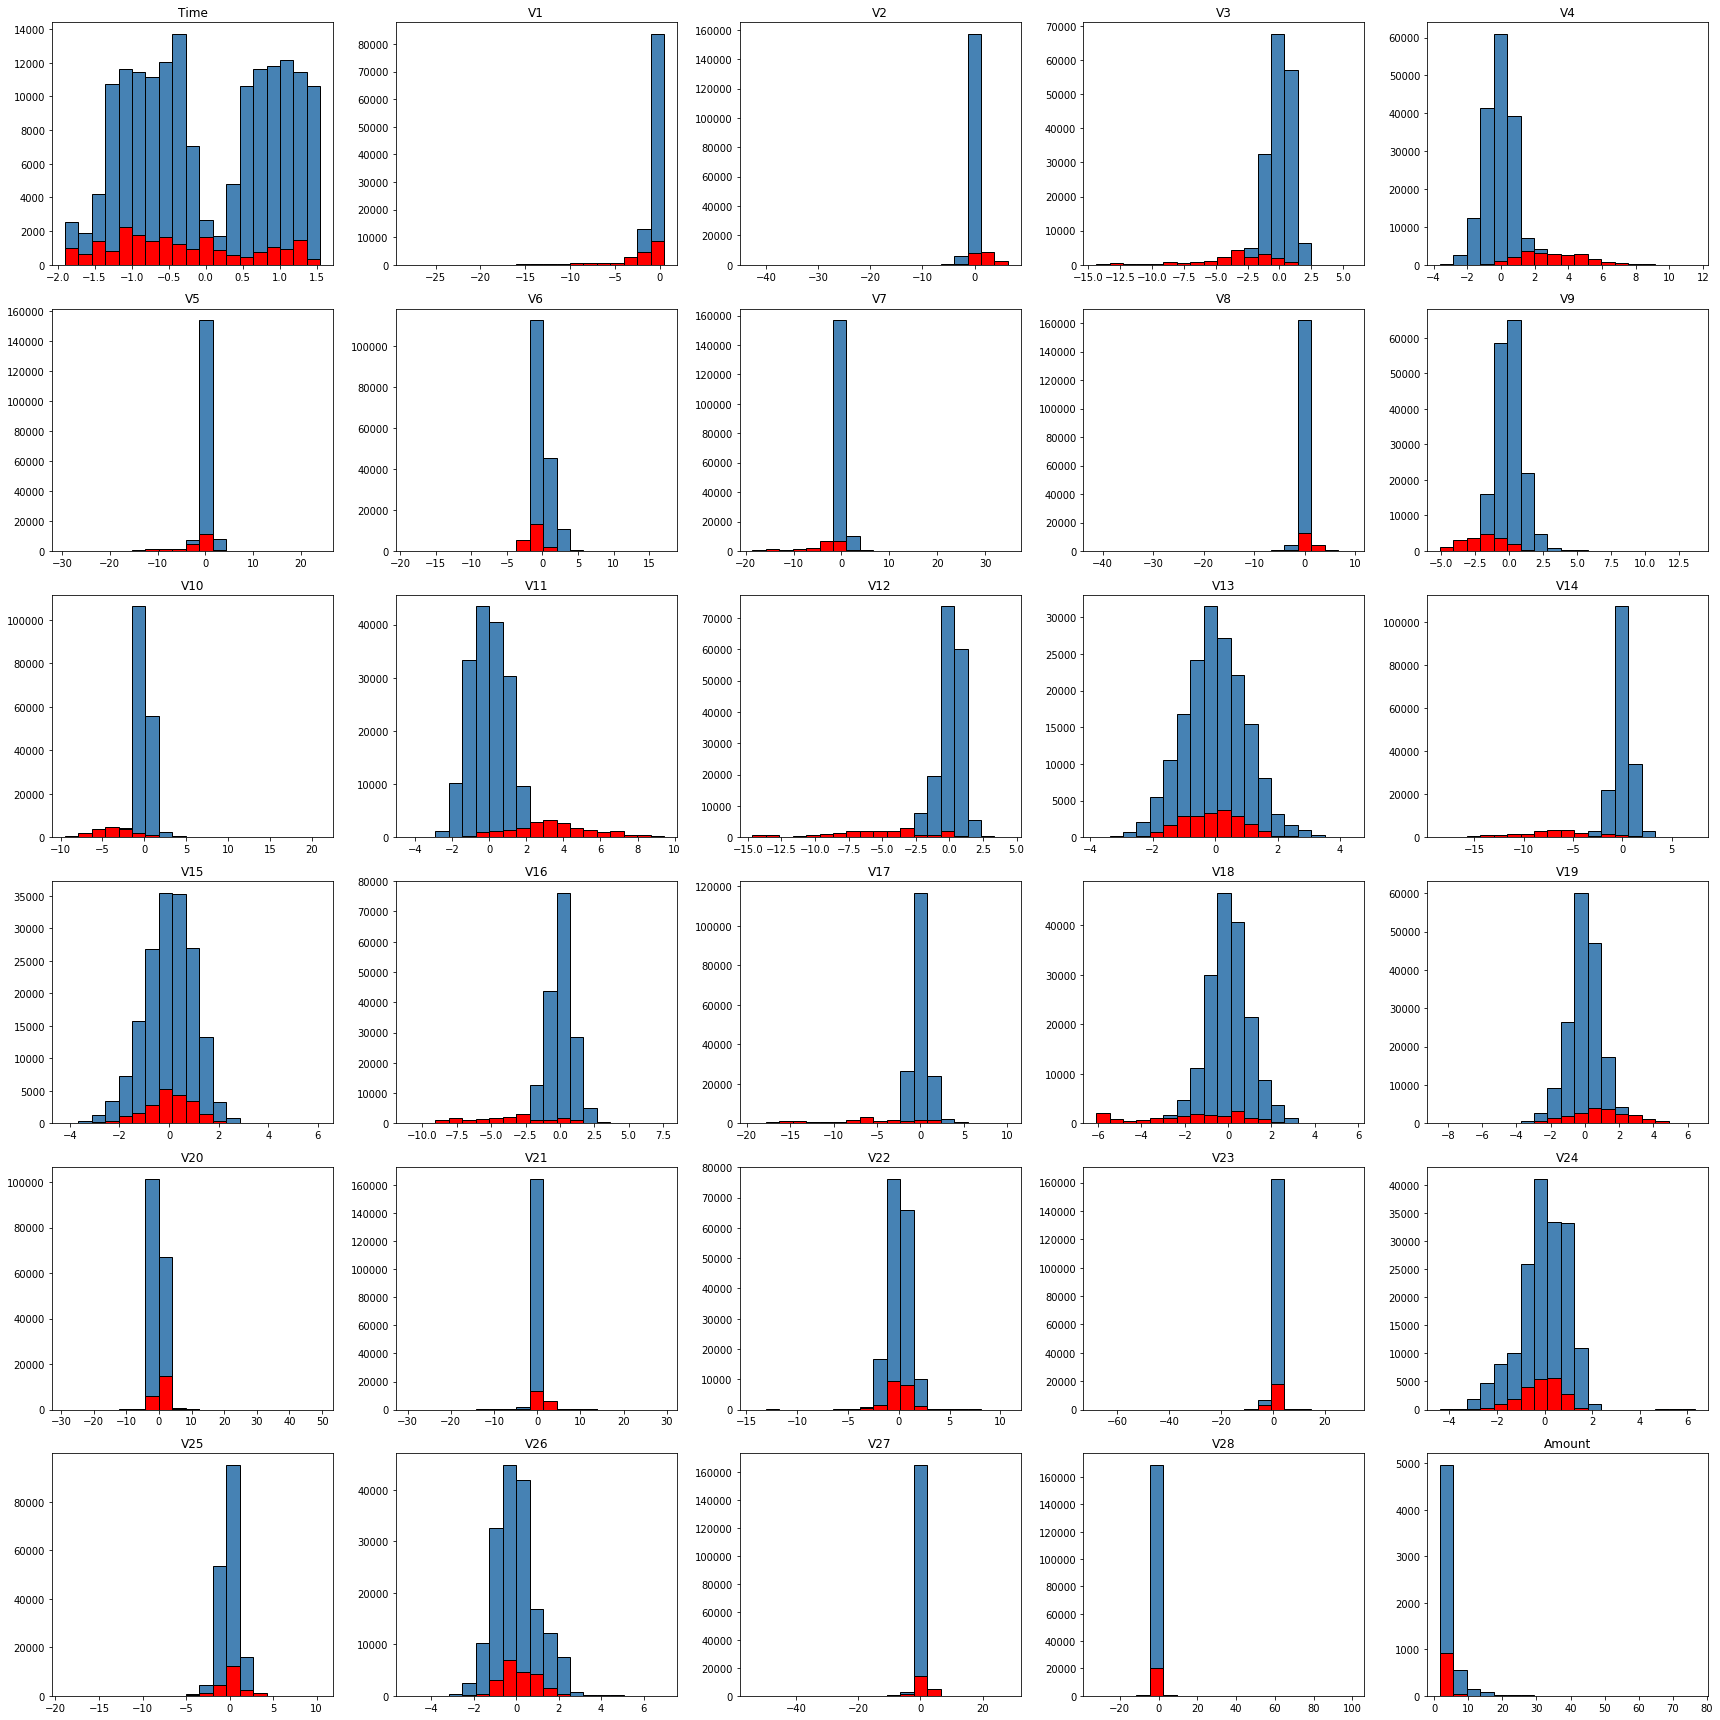

In [22]:
fig = plt.figure(figsize = (20, 20))
ax = fig.gca()

fraud_hist_data = data_train[data_train['Class'] == -1][col_names]
clients_hist_data = data_train[data_train['Class'] == 1][col_names]

for num, col in enumerate(col_names):
    plt.subplot(6, 5, num + 1)
    
    min_x = min(clients_hist_data[col])
    max_x = max(clients_hist_data[col])
    one_bar = (max_x-min_x)/20
    min_x = min_x + one_bar/2
    max_x = max_x - one_bar/2 + 0.010
    bins = list(np.arange(min_x, max_x, one_bar))
    
    plt.hist(clients_hist_data[col], bins=bins, color='steelblue', edgecolor='black', linewidth=1.0)  
    plt.hist(fraud_hist_data[col], bins=bins, color='red', edgecolor='black', linewidth=1.0)
    plt.title(col)

plt.tight_layout(rect=(0, 0, 1.2, 1.2))   

I performed histograms after resampling because before it was pretty impossible to find fraud data on bars (there was too few of them). Now we gain intuition about behaviour of fraud's instances. Coclusions are similar like in the case of correlation matrix but gives us more info about data distribution. Columns $V_{4}$,  $V_{12}$,  $V_{14}$ and  $V_{17}$ are the most significant ones.

## Preparation for comparing predicting models

In [23]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier, IsolationForest

from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, roc_auc_score

In [24]:
def prepare_model(clf, param_grid, X_train, y_train, score_type='roc_auc', list_of_selected_columns=None):
    """
    Function use GridSearch to find best model hyperparameters and decide 
    if using all columns or only the most important ones will train the 
    best model.
    
    :param clf: sklearn model with base class - BaseEstimator.
    
    :param dict param_grid: Dictionary with parameters names (string) 
    as keys and lists of parameter settings to try as values, 
    or a list of such dictionaries, in which case the grids spanned 
    by each dictionary in the list are explored. 
    This enables searching over any sequence of parameter settings.
    
    :param pandas.core.frame.DataFrame X_train: Traininig data instances.
    :param pandas.core.frame.DataFrame y_train: Labels for traininig data instances.
    :param str score_type: type of scoring during GridSearch
    :param list list_of_selected_columns: list of columns used during training.
    If None every column is used.
    
    :returns: 
        - imblearn.pipeline.Pipeline best -  best model after fitting the data.
        - dict grid.best_params_ - Dictionary with best params.
        - imblearn.pipeline.Pipeline grid.best_estimator_ - best model before fitting the data.
        - str all_or_selected - information whether the training on all columns was more effective 
        than the training on selected columns
    """
    
    all_or_selected = 'all'
    
    list_of_keys = list(param_grid.keys())
    for old_key in list_of_keys :
        param_grid['clf__' + old_key] = param_grid.pop(old_key)
        
    model = Pipeline([
        ('clf', clf)
    ])

    grid = GridSearchCV(model, param_grid, cv=3, scoring=score_type, verbose=1)
    grid.fit(X_train, y_train)
    
    params = grid.best_params_
    estimator = grid.best_estimator_
    best = estimator.fit(X_train, y_train)
    
    if list_of_selected_columns != None:
        grid_2 = GridSearchCV(model, params, cv=3, scoring=score_type, verbose=1)
        grid_2.fit(X_train[list_of_selected_columns], y_train)
        
        if grid_2.best_score_ > grid.best_score_:
            params = grid_2.best_params_
            estimator = grid_2.best_estimator_
            best = estimator.fit(X_train, y_train)
            all_or_selected = 'selected'
            return best, grid.best_params_, grid.best_estimator_, all_or_selected
        
    return best, grid.best_params_, grid.best_estimator_, all_or_selected

In [25]:
def model_tests(model, X_test, y_test):
    """
    Function printing info about model performance on test set.

    :param model: sklearn model before fitting.
    :param pandas.core.frame.DataFrame: Test data instances.
    :param pandas.core.frame.DataFrame: Label for test data instances.
    
    """
    print('Best params: \t', model[1])
    print('')
    print('Best columns amount: \t', model[3])
    print('')
    
    predictions = model[0].predict(X_test)
    predictions = [1 if i == -1 else 0 for i in predictions]
    y_test_original = [1 if i == -1 else 0 for i in y_test.values]
    
    print('Precision score: \t', precision_score(y_test_original, predictions))
    print('Recall score: \t', recall_score(y_test_original, predictions))
    print('F1 score: \t', f1_score(y_test_original, predictions))
    print('')
    print('Roc AUC Score: \t', roc_auc_score(y_test_original, predictions))
    print('')
    print(classification_report(y_test_original, predictions, target_names=['Client', 'Fraud']))

## Training models

In [26]:
if 'clf_logistic_regression.sav' in os.listdir(models_dir):
    clf_logistic_regression = pickle.load(open(models_dir + '/clf_logistic_regression.sav', 'rb'))
else:
    clf_logistic_regression = prepare_model(LogisticRegression(), 
                                            {'solver':['lbfgs','sag', 'saga'], 
                                             'max_iter':[1e4]}, 
                                            X_train_1, y_train_1)
    filename = models_dir + '/clf_logistic_regression.sav'
    pickle.dump(clf_logistic_regression, open(filename, 'wb'))

In [27]:
if 'clf_decision_tree.sav' in os.listdir(models_dir):
    clf_decision_tree = pickle.load(open(models_dir + '/clf_decision_tree.sav', 'rb'))
else:
    clf_decision_tree = prepare_model(DecisionTreeClassifier(), 
                                            {'min_samples_split':[20, 390, 1000], 
                                             'max_depth':[None, 5, 10, 20],
                                            'random_state':[12]}, 
                                            X_train_2, y_train_2)
    filename = models_dir + '/clf_decision_tree.sav'
    pickle.dump(clf_decision_tree, open(filename, 'wb'))

In [28]:
if 'clf_svc.sav' in os.listdir(models_dir):
    clf_svc = pickle.load(open(models_dir + '/clf_svc.sav', 'rb'))
else:
    clf_svc = prepare_model(SVC(), {'C':[1.0, 2.0], 
                                    'class_weight':['balanced'],
                                    'random_state':[12],
                                    'gamma':['scale'],
                                    'kernel':['poly', 'rbf', 'sigmoid']}, 
                                     X_train_3, y_train_3)
    filename = models_dir + '/clf_svc.sav'
    pickle.dump(clf_svc, open(filename, 'wb'))

In [29]:
if 'clf_sgd.sav' in os.listdir(models_dir):
    clf_sgd = pickle.load(open(models_dir + '/clf_sgd.sav', 'rb'))
else:
    clf_sgd = prepare_model(SGDClassifier(), {'penalty':['l1', 'l2', 'elasticnet'],
                                    'alpha':[0.0001, 0.01],
                                    'random_state':[12]},
                                     X_train_4, y_train_4)
    filename = models_dir + '/clf_sgd.sav'
    pickle.dump(clf_sgd, open(filename, 'wb'))

In [30]:
if 'clf_gausian.sav' in os.listdir(models_dir):
    clf_gausian = pickle.load(open(models_dir + '/clf_gausian.sav', 'rb'))
else:
    clf_gausian = prepare_model(GaussianNB(), 
                                            {'priors':[None]}, 
                                            X_train_5, y_train_5)
    filename = models_dir + '/clf_gausian.sav'
    pickle.dump(clf_gausian, open(filename, 'wb'))

In [31]:
if 'clf_gradient_boosting.sav' in os.listdir(models_dir):
    clf_gradient_boosting = pickle.load(open(models_dir + '/clf_gradient_boosting.sav', 'rb'))
else:
    clf_gradient_boosting = prepare_model(GradientBoostingClassifier(), 
                            {'learning_rate':[0.1, 0.05],
                             'max_depth':[None, 10], 'n_estimators':[100, 200],
                             'random_state':[12]}, X_train_6, y_train_6)
    filename = models_dir + '/clf_gradient_boosting.sav'
    pickle.dump(clf_gradient_boosting, open(filename, 'wb'))

In [32]:
if 'clf_random_forest.sav' in os.listdir(models_dir):
    clf_random_forest = pickle.load(open(models_dir + '/clf_random_forest.sav', 'rb'))
else:
    clf_random_forest = prepare_model(RandomForestClassifier(), 
                            {'max_depth':[None, 10, 15], 'n_estimators':[100, 200],
                             'random_state':[12], 'criterion':['gini','entropy']}, X_train_7, y_train_7)
    filename = models_dir + '/clf_random_forest.sav'
    pickle.dump(clf_random_forest, open(filename, 'wb'))

In [33]:
if 'clf_isolation_forest.sav' in os.listdir(models_dir):
    clf_isolation_forest = pickle.load(open(models_dir + '/clf_isolation_forest.sav', 'rb'))
else:
    clf_isolation_forest = IsolationForest(contamination=0.0017, max_samples=len(X_train_7),
                          verbose=1, behaviour="new")
    clf_isolation_forest.fit(X_train)
    
    filename = models_dir + '/clf_isolation_forest.sav'
    pickle.dump(clf_isolation_forest, open(filename, 'wb'))

## Models evaluation

### Single classifiers

In [34]:
model_tests(clf_logistic_regression, X_test, y_test)

Best params: 	 {'clf__max_iter': 10000.0, 'clf__solver': 'lbfgs'}

Best columns amount: 	 all

Precision score: 	 0.05354200988467875
Recall score: 	 0.8783783783783784
F1 score: 	 0.10093167701863355

Roc AUC Score: 	 0.9257181361256678

              precision    recall  f1-score   support

      Client       1.00      0.97      0.99     42647
       Fraud       0.05      0.88      0.10        74

    accuracy                           0.97     42721
   macro avg       0.53      0.93      0.54     42721
weighted avg       1.00      0.97      0.98     42721



We could assume that dependencies between dependent and independent variables is not a linear transformation because increasing the recall score highly decreased our precision.

In [35]:
model_tests(clf_decision_tree, X_test, y_test)

Best params: 	 {'clf__max_depth': None, 'clf__min_samples_split': 390, 'clf__random_state': 12}

Best columns amount: 	 all

Precision score: 	 0.03855721393034826
Recall score: 	 0.8378378378378378
F1 score: 	 0.07372175980975029

Roc AUC Score: 	 0.9007933766767915

              precision    recall  f1-score   support

      Client       1.00      0.96      0.98     42647
       Fraud       0.04      0.84      0.07        74

    accuracy                           0.96     42721
   macro avg       0.52      0.90      0.53     42721
weighted avg       1.00      0.96      0.98     42721



We pay for high recall with very small precision. Probably one decision tree could not find enough complex decision boundary.

In [36]:
model_tests(clf_svc, X_test, y_test)

Best params: 	 {'clf__C': 2.0, 'clf__class_weight': 'balanced', 'clf__gamma': 'scale', 'clf__kernel': 'rbf', 'clf__random_state': 12}

Best columns amount: 	 all

Precision score: 	 0.0995405819295559
Recall score: 	 0.8783783783783784
F1 score: 	 0.17881705639614853

Roc AUC Score: 	 0.9322953865770478

              precision    recall  f1-score   support

      Client       1.00      0.99      0.99     42647
       Fraud       0.10      0.88      0.18        74

    accuracy                           0.99     42721
   macro avg       0.55      0.93      0.59     42721
weighted avg       1.00      0.99      0.99     42721



For kernel: 'rbf' value depends only on the distance between the input and some fixed point. Seems that it's not enough for our data, beacause increasing recall score highly decreased precision score for fraud detections.

In [37]:
model_tests(clf_sgd, X_test, y_test)

Best params: 	 {'clf__alpha': 0.0001, 'clf__penalty': 'l1', 'clf__random_state': 12}

Best columns amount: 	 all

Precision score: 	 0.058469475494411005
Recall score: 	 0.918918918918919
F1 score: 	 0.1099434114793856

Roc AUC Score: 	 0.9466215107174611

              precision    recall  f1-score   support

      Client       1.00      0.97      0.99     42647
       Fraud       0.06      0.92      0.11        74

    accuracy                           0.97     42721
   macro avg       0.53      0.95      0.55     42721
weighted avg       1.00      0.97      0.99     42721



In essence gradient descent is kind of a greedy approach. The gradient is nothing but the direction along which the loss function decreases the fastest, and descending this means finding the locally optimal choice at each iteration.There is no guarantee that the optimization algorithm will find a global minimum. If loss function is not convex function our data could be too complex to train model with high recall and sufficient precision.

In [38]:
model_tests(clf_gausian, X_test, y_test)

Best params: 	 {'clf__priors': None}

Best columns amount: 	 all

Precision score: 	 0.054924242424242424
Recall score: 	 0.7837837837837838
F1 score: 	 0.10265486725663717

Roc AUC Score: 	 0.8801911860978149

              precision    recall  f1-score   support

      Client       1.00      0.98      0.99     42647
       Fraud       0.05      0.78      0.10        74

    accuracy                           0.98     42721
   macro avg       0.53      0.88      0.55     42721
weighted avg       1.00      0.98      0.99     42721



Naive Bayes assumes that all features are independent, so if the variables are correlated, the predictions will be weak. Our data functions are mostly PCA breakdown results, so it was obvious that this model would not be good enough.

### Ensembled classifiers

Individual models gave us a high recall, but the precision was insufficient. People don't like being disturbed, so we can't take action against users knowing that only 1 in 20 suspects are really guilty. Ensembled classifiers could be helpful in increasing our precision withou decreasing recall.

In [39]:
model_tests(clf_gradient_boosting, X_test, y_test)

Best params: 	 {'clf__learning_rate': 0.05, 'clf__max_depth': 10, 'clf__n_estimators': 200, 'clf__random_state': 12}

Best columns amount: 	 all

Precision score: 	 0.41843971631205673
Recall score: 	 0.7972972972972973
F1 score: 	 0.5488372093023256

Roc AUC Score: 	 0.8976872680122616

              precision    recall  f1-score   support

      Client       1.00      1.00      1.00     42647
       Fraud       0.42      0.80      0.55        74

    accuracy                           1.00     42721
   macro avg       0.71      0.90      0.77     42721
weighted avg       1.00      1.00      1.00     42721



Gradient Boosting is a method, which builds on weak classifiers. The idea is to add a classifier at a time, so that the next classifier is trained to improve the already trained ensemble. In this way we increased complexity of our model, however now it has much better precision.

In [40]:
model_tests(clf_random_forest, X_test, y_test)

Best params: 	 {'clf__criterion': 'entropy', 'clf__max_depth': None, 'clf__n_estimators': 100, 'clf__random_state': 12}

Best columns amount: 	 all

Precision score: 	 0.686046511627907
Recall score: 	 0.7972972972972973
F1 score: 	 0.7375

Roc AUC Score: 	 0.8983320964878871

              precision    recall  f1-score   support

      Client       1.00      1.00      1.00     42647
       Fraud       0.69      0.80      0.74        74

    accuracy                           1.00     42721
   macro avg       0.84      0.90      0.87     42721
weighted avg       1.00      1.00      1.00     42721



Random forests outperform single decision trees because:

$\cdot$ Trees are unpruned. A random forest tree is fully grown and unpruned, what brings about the feature space is split into more and smaller regions.

$\cdot$ Trees are diverse. Each random forest tree is learned on a random sample, and at each node, a random set of features are considered for splitting. 

Both mechanisms create diversity among the trees. Unpruned and diverse trees lead to a high resolution in the feature space. For continuous features, it means a smoother decision boundary.

In [41]:
predictions = clf_isolation_forest.predict(X_test)

predictions = [1 if i == -1 else 0 for i in predictions]
y_test_original = [1 if i == -1 else 0 for i in y_test.values]

print('Precision score: \t', precision_score(y_test_original, predictions))
print('Recall score: \t', recall_score(y_test_original, predictions))
print('F1 score: \t', f1_score(y_test_original, predictions))
print('Roc AUC Score: \t', roc_auc_score(y_test_original, predictions))

print('')
print(classification_report(y_test_original, predictions, target_names=['Client', 'Fraud']))

Precision score: 	 0.3559322033898305
Recall score: 	 0.28378378378378377
F1 score: 	 0.3157894736842105
Roc AUC Score: 	 0.6414463740360051

              precision    recall  f1-score   support

      Client       1.00      1.00      1.00     42647
       Fraud       0.36      0.28      0.32        74

    accuracy                           1.00     42721
   macro avg       0.68      0.64      0.66     42721
weighted avg       1.00      1.00      1.00     42721



In [42]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    
    tresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(round(j, 2), round(i, 2), round(cm[i, j], 2), horizontalalignment='center', color='magenta' if cm[i, j] > tresh else 'black')
    
    ax = plt.gca()  # only to illustrate what `ax` is
    ax.autoscale(enable=True, axis='y', tight=False)
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[42609    38]
 [   53    21]]


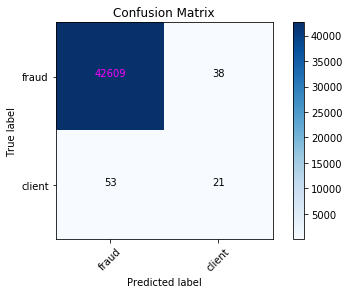

In [43]:
cm = confusion_matrix(y_test_original, predictions)
cm_plot_labels = ['fraud', 'client']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

### Voting Classifiers with evaluation

We managed to train two models with much better results than the previous ones. Now we should try to combine them into one classifier. It is highly possible that the result can give us even more satisfactory predictions.

In [44]:
if 'voting_clf.sav' in os.listdir(models_dir):
    voting_clf = pickle.load(open(models_dir + '/voting_clf.sav', 'rb'))
else:
    voting_clf = VotingClassifier(estimators=[
        ('p1', clf_gradient_boosting[2]), 
        ('p2', clf_random_forest[2]),
        ('p3', clf_random_forest[2])
    ], voting='hard')
    
    voting_clf.fit(X_train_8, y_train_8)

    filename = models_dir + '/voting_clf.sav'
    pickle.dump(voting_clf, open(filename, 'wb'))
    

predictions = voting_clf.predict(X_test)

predictions = [1 if i == -1 else 0 for i in predictions]
y_test_original = [1 if i == -1 else 0 for i in y_test.values]

print('Precision score: \t', precision_score(y_test_original, predictions))
print('Recall score: \t', recall_score(y_test_original, predictions))
print('F1 score: \t', f1_score(y_test_original, predictions))
print('Roc AUC Score: \t', roc_auc_score(y_test_original, predictions))

print('')
print(classification_report(y_test_original, predictions, target_names=['Client', 'Fraud']))

Precision score: 	 0.6451612903225806
Recall score: 	 0.8108108108108109
F1 score: 	 0.718562874251497
Roc AUC Score: 	 0.9050185083200302

              precision    recall  f1-score   support

      Client       1.00      1.00      1.00     42647
       Fraud       0.65      0.81      0.72        74

    accuracy                           1.00     42721
   macro avg       0.82      0.91      0.86     42721
weighted avg       1.00      1.00      1.00     42721



F1-score for this model is 0.02 wore than for Random Forest. Could we do better? 

In [45]:
from mlxtend.classifier import EnsembleVoteClassifier

if 'voting_clf_2.sav' in os.listdir(models_dir):
    voting_clf_2 = pickle.load(open(models_dir + '/voting_clf_2.sav', 'rb'))
else:
    voting_clf_2 = EnsembleVoteClassifier(clfs=[clf_gradient_boosting[2], 
                                                clf_random_forest[2],
                                                clf_random_forest[2],
                                                clf_isolation_forest
                                               ], voting='hard', refit=False)
    
    voting_clf_2.fit(X_train_8, y_train_8)

    filename = models_dir + '/voting_clf_2.sav'
    pickle.dump(voting_clf_2, open(filename, 'wb'))
    

predictions = voting_clf_2.predict(X_test)

predictions = [1 if i == -1 else 0 for i in predictions]
y_test_original = [1 if i == -1 else 0 for i in y_test.values]

print('Precision score: \t', precision_score(y_test_original, predictions))
print('Recall score: \t', recall_score(y_test_original, predictions))
print('F1 score: \t', f1_score(y_test_original, predictions))
print('Roc AUC Score: \t', roc_auc_score(y_test_original, predictions))

print('')
print(classification_report(y_test_original, predictions, target_names=['Client', 'Fraud']))

Precision score: 	 0.6781609195402298
Recall score: 	 0.7972972972972973
F1 score: 	 0.732919254658385
Roc AUC Score: 	 0.8983203723337848

              precision    recall  f1-score   support

      Client       1.00      1.00      1.00     42647
       Fraud       0.68      0.80      0.73        74

    accuracy                           1.00     42721
   macro avg       0.84      0.90      0.87     42721
weighted avg       1.00      1.00      1.00     42721



We improved f_1 score by 0.01. I will try to boost it a little bit more.

In [46]:
data_train = np.c_[X_train_resampled, y_train_resampled]
data_train = pd.DataFrame(data_train, columns=data.columns.values)

data_train_1 = data_train[data_train['Class'] == -1]
data_train_0 = data_train[data_train['Class'] == 1]

border = int(len(data_train_0)/5)
indices = [i*border for i in range(5)]
indices = indices + [len(data_train_0) - 1]

data_train_0_chunks = [data_train_0.iloc[indices[n]:indices[n+1]] for n in range(len(indices)-1)]

list_of_training_sets = []
col_names = list(data.columns.values)
col_names.pop()

for i in data_train_0_chunks:
    var = pd.concat([i, data_train_1])
    var_y = var['Class']
    var_X = var[col_names]
    list_of_training_sets.append([var_X, var_y])

In [47]:
X_train_1, y_train_1 = list_of_training_sets[0][0], list_of_training_sets[0][1]
X_train_2, y_train_2 = list_of_training_sets[1][0], list_of_training_sets[1][1]
X_train_3, y_train_3 = list_of_training_sets[2][0], list_of_training_sets[2][1]
X_train_4, y_train_4 = list_of_training_sets[3][0], list_of_training_sets[3][1]

In [48]:
if 'voting_clf_3.sav' in os.listdir(models_dir):
    voting_clf_3 = pickle.load(open(models_dir + '/voting_clf_3.sav', 'rb'))
else:
    clf_gradient_boosting_1 = clf_gradient_boosting[2].fit(X_train_1, y_train_1)
    clf_random_forest_1 = clf_random_forest[2].fit(X_train_2, y_train_2)
    clf_random_forest_2 = clf_random_forest[2].fit(X_train_3, y_train_3)
    
    voting_clf_3 = EnsembleVoteClassifier(clfs=[clf_gradient_boosting_1, 
                                                clf_random_forest_1,
                                                clf_random_forest_2,
                                                clf_isolation_forest
                                               ], voting='hard', refit=False)
    
    voting_clf_3.fit(X_train_5, y_train_5)

    filename = models_dir + '/voting_clf_3.sav'
    pickle.dump(voting_clf_3, open(filename, 'wb'))
    

predictions = voting_clf_3.predict(X_test)

predictions = [1 if i == -1 else 0 for i in predictions]
y_test_original = [1 if i == -1 else 0 for i in y_test.values]

print('Precision score: \t', precision_score(y_test_original, predictions))
print('Recall score: \t', recall_score(y_test_original, predictions))
print('F1 score: \t', f1_score(y_test_original, predictions))
print('Roc AUC Score: \t', roc_auc_score(y_test_original, predictions))

print('')
print(classification_report(y_test_original, predictions, target_names=['Client', 'Fraud']))

Precision score: 	 0.7631578947368421
Recall score: 	 0.7837837837837838
F1 score: 	 0.7733333333333334
Roc AUC Score: 	 0.8916808571180508

              precision    recall  f1-score   support

      Client       1.00      1.00      1.00     42647
       Fraud       0.76      0.78      0.77        74

    accuracy                           1.00     42721
   macro avg       0.88      0.89      0.89     42721
weighted avg       1.00      1.00      1.00     42721



This model has f1-score higher by 0.03 that best aproach from before (Random Forest).

We need to return from the notation {-1 (fraud), 1(client)} to the notation {1(fraud), 0(client)}, because the charts offered by the module sklearn.metrics evaluate according to the class equal to 1. 

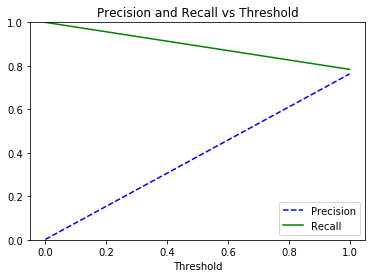

In [49]:
from sklearn.metrics import precision_recall_curve
predictions = voting_clf_3.predict(X_test)
predictions = [1 if i == -1 else 0 for i in predictions]
y_test_original = [1 if i == -1 else 0 for i in y_test.values]

precisions, recalls, thresholds = precision_recall_curve(y_test_original, predictions)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Function plotting precision and recall curve. The independent variables is 
    threshold nd the dependent variables are precision and recall.

    :param numpy.ndarray precisions: Array of precisions for model's predictions.
    :param numpy.ndarray recalls: Array of recalls for model's predictions.
    :param numpy.ndarray thresholds: Array of thresholds for model's predictions.
    """
    
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="best")
    plt.ylim([0, 1])
    plt.title('Precision and Recall vs Threshold')
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

Text(0.5, 1.0, 'Precision-Recall curve')

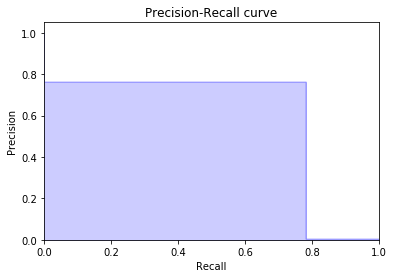

In [50]:
from inspect import signature

step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})
plt.step(recalls, precisions, color='b', alpha=0.2, where='post')
plt.fill_between(recalls, precisions, alpha=0.2, color='b', **step_kwargs)


plt.xlabel("Recall")
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve')

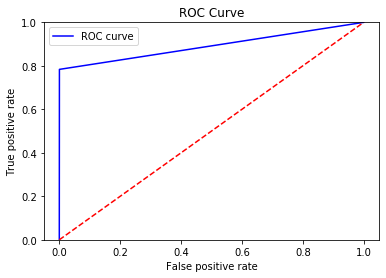

In [51]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test_original, predictions)

def plot_roc_curve(fpr, tpr):
    """
    Function plotting ROC curve. The independent variables is 
    False positive rate and the dependent variables is True positive rate.

    :param numpy.ndarray fpr: Array of False positives rates
    :param numpy.ndarray tpr: Array of True positives rates.
    """
    
    plt.plot(fpr, tpr, "b-", label="ROC curve")
    plt.plot([0, 1], [0,1], "r--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.legend(loc="best")
    plt.ylim([0, 1])
    plt.title('ROC Curve')
plot_roc_curve(fpr, tpr)
plt.show()

Confusion matrix, without normalization
[[42629    18]
 [   16    58]]


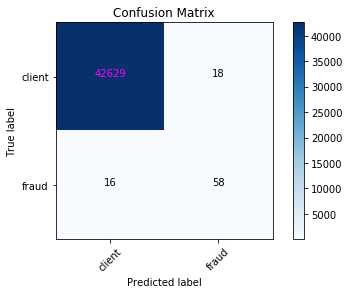

In [52]:
cm = confusion_matrix(y_test_original, predictions)

cm_plot_labels = ['client', 'fraud']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

Normalized confusion matrix
[[9.99577930e-01 4.22069548e-04]
 [2.16216216e-01 7.83783784e-01]]


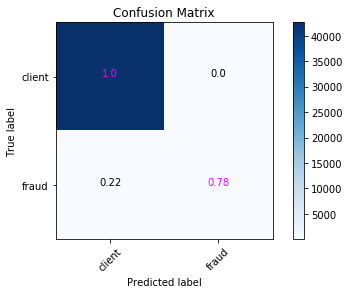

In [53]:
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix', normalize=True)